In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df = pd.read_csv('training.csv')

In [37]:
df.columns

Index(['Date', 'season_start', 'gameweek', 'prev_season_avg_HS',
       'prev_season_avg_HST', 'prev_season_avg_HF', 'prev_season_avg_HC',
       'prev_season_avg_HY', 'prev_season_avg_HR', 'prev_season_avg_AS',
       'prev_season_avg_AST', 'prev_season_avg_AF', 'prev_season_avg_AC',
       'prev_season_avg_AY', 'last_n_seasons_avg_HS', 'last_n_seasons_avg_HST',
       'last_n_seasons_avg_HF', 'last_n_seasons_avg_HC',
       'last_n_seasons_avg_HY', 'last_n_seasons_avg_HR',
       'last_n_seasons_avg_AS', 'last_n_seasons_avg_AST',
       'last_n_seasons_avg_AF', 'last_n_seasons_avg_AC',
       'last_n_seasons_avg_AY', 'season_so_far_avg_FTHG',
       'season_so_far_avg_FTAG', 'season_so_far_avg_Home xG',
       'season_so_far_avg_Away xG', 'last5_avg_FTHG', 'last5_avg_FTAG',
       'last5_avg_Home xG', 'last5_avg_Away xG', 'home_home_win_streak',
       'away_away_win_streak', 'home_total_win_streak',
       'away_total_win_streak', 'home_home_losing_streak',
       'away_away_losing_

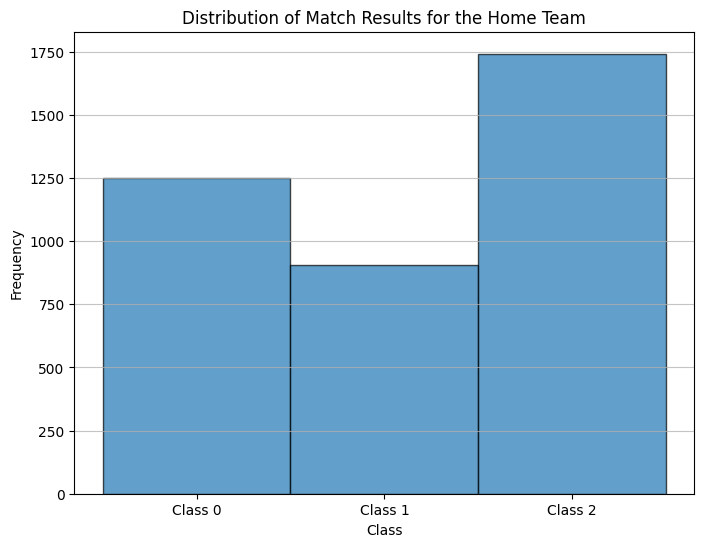

In [38]:
plt.figure(figsize=(8, 6))
plt.hist(df['ft_result_encoded'], bins=np.arange(-0.5, 3.5, 1), edgecolor='black', alpha=0.7)
plt.xticks([0, 1, 2], ['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Match Results for the Home Team')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [39]:
from scipy.stats import entropy
entropy(df['ft_result_encoded'].value_counts(normalize=True))

np.float64(1.0639285626149124)

ValueError: num must be an integer with 1 <= num <= 16, not 17

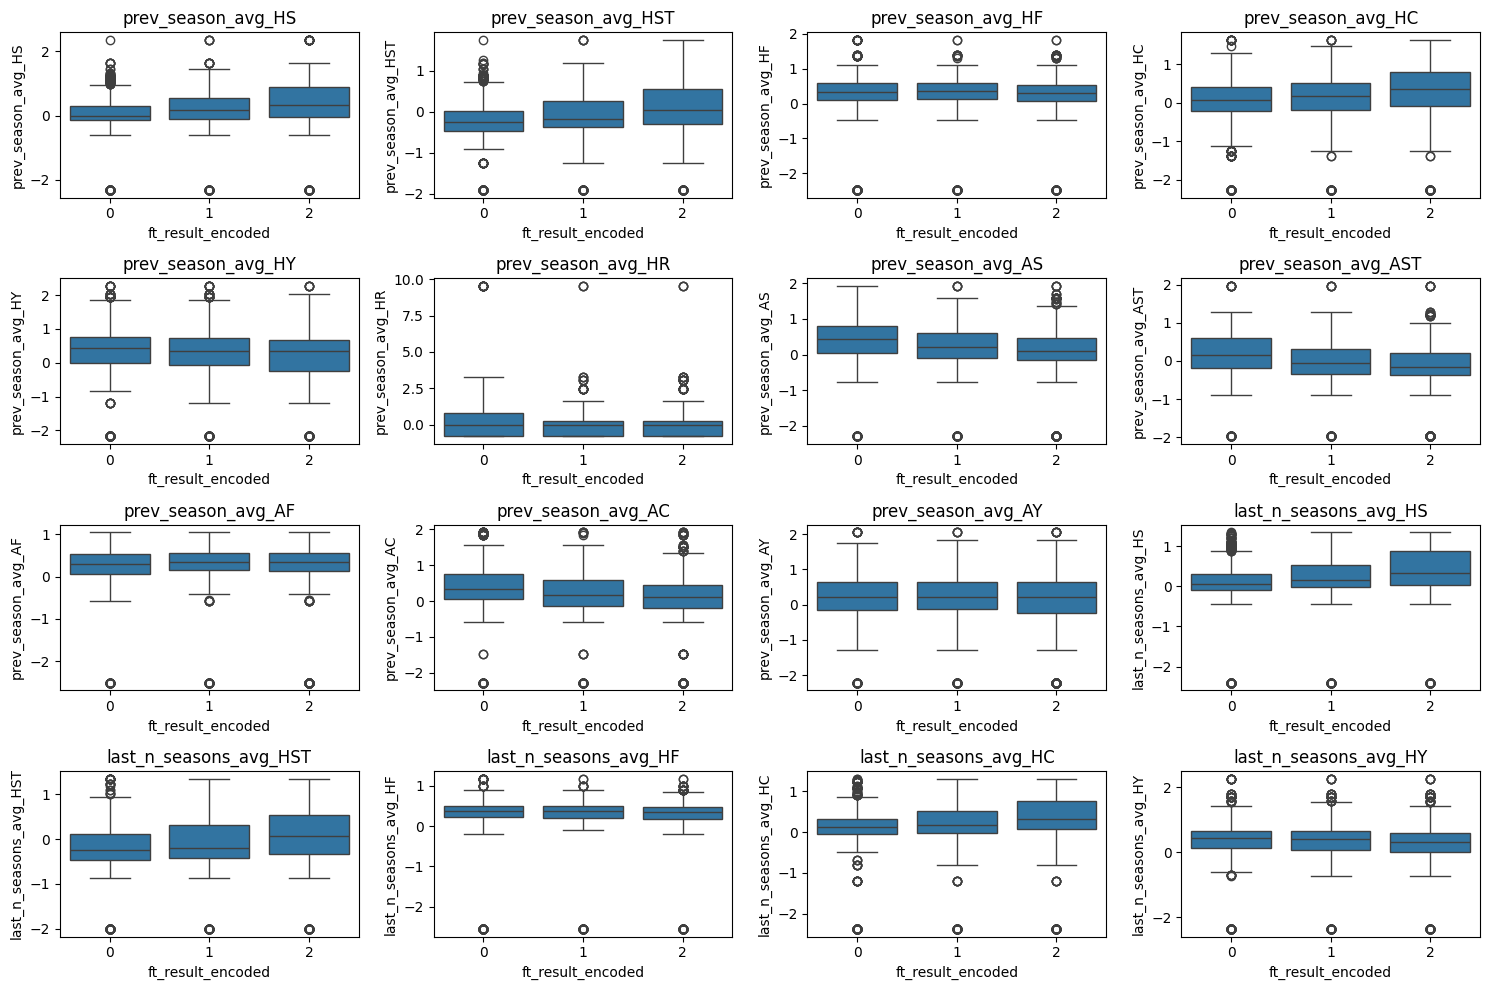

In [40]:
numerical_cols = df.drop(columns=['ft_result_encoded', 'Date', 'gameweek', 'season_start']).select_dtypes(include=np.number).columns
plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols, start=1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='ft_result_encoded', y=col, data=df)
    plt.title(f'{col}')

    plt.tight_layout()
plt.show()

In [ ]:
# compare distribution of ft_result_encoded over time (season)
plt.figure(figsize=(12, 6))
sns.countplot(x='season_start', hue='ft_result_encoded', data=df)
plt.xlabel('Season Start Year')
plt.ylabel('Count')
plt.title('Distribution of Match Results Over Seasons')
plt.show()

In [ ]:
# plot entropy over seasons
season_entropy = df.groupby('season_start')['ft_result_encoded'].apply(lambda x: entropy(x.value_counts(normalize=True)))
plt.figure(figsize=(10, 5))
plt.plot(season_entropy.index, season_entropy.values, marker='o')
plt.xlabel('Season Start Year')
plt.ylabel('Entropy of Match Results')
plt.ylim(0, np.log(3) + 0.1)
plt.title('Entropy of Match Results Over Seasons')
plt.hlines(y=np.log(3), xmin=2014, xmax=2026, colors='red', linestyles='--', label='Max entropy (ln(3))')
plt.show()

In [58]:
df2 = df.copy()

# 1. Assign points per match
df2['home_points'] = df2['ft_result_encoded'].map({2: 3, 1: 1, 0: 0})
df2['away_points'] = df2['ft_result_encoded'].map({2: 0, 1: 1, 0: 3})

# 2. Aggregate home points per team per season
home_points = (
    df2.groupby(['season_start', 'home_team_encoded'], as_index=False)['home_points']
       .sum()
       .rename(columns={'home_team_encoded': 'team_encoded',
                        'home_points': 'points'})
)

# 3. Aggregate away points per team per season
away_points = (
    df2.groupby(['season_start', 'away_team_encoded'], as_index=False)['away_points']
       .sum()
       .rename(columns={'away_team_encoded': 'team_encoded',
                        'away_points': 'points'})
)

# 4. Combine home + away points
season_points = pd.concat([home_points, away_points], ignore_index=True)

# 5. Total points per team per season
season_points = (
    season_points
    .groupby(['season_start', 'team_encoded'], as_index=False)['points']
    .sum()
)

# 6. Who won each season?
winners = (
    season_points
    .sort_values(['season_start', 'points'], ascending=[True, False])
    .groupby('season_start', as_index=False)
    .first()
    .rename(columns={'team_encoded': 'winner_team_encoded'})
)

print(winners.head())

   season_start  winner_team_encoded  points
0        2015.0                   19      81
1        2016.0                   11      93
2        2017.0                   22     100
3        2018.0                   22      98
4        2019.0                   20      86


In [59]:
df2 = df2.merge(winners, on='season_start', how='left')

df2['home_is_future_winner'] = (df2['home_team_encoded'] == df2['winner_team_encoded']).astype(int)
df2['away_is_future_winner'] = (df2['away_team_encoded'] == df2['winner_team_encoded']).astype(int)


In [60]:
home_df = df2.copy()
home_df['team_encoded'] = home_df['home_team_encoded']
home_df['is_winner'] = home_df['home_is_future_winner']

away_df = df2.copy()
away_df['team_encoded'] = away_df['away_team_encoded']
away_df['is_winner'] = away_df['away_is_future_winner']

team_games = pd.concat([home_df, away_df], ignore_index=True)

In [78]:
import pickle

with open("pipeline.pkl", "rb") as f:
    pipeline = pickle.load(f)

result_encoder = pipeline["result_encoder"]
team_encoder = pipeline['team_encoder']

encoded_winners = winners.copy()
encoded_winners['winner_team'] = team_encoder.inverse_transform(encoded_winners['winner_team_encoded'])
print(encoded_winners[['season_start', 'winner_team']])

    season_start winner_team
0         2015.0   Leicester
1         2016.0     Chelsea
2         2017.0    Man City
3         2018.0    Man City
4         2019.0   Liverpool
5         2020.0    Man City
6         2021.0    Man City
7         2022.0    Man City
8         2023.0    Man City
9         2024.0   Liverpool
10        2025.0     Arsenal


In [61]:
X.isna().sum().sort_values(ascending=False).head(20)


home_Departures                   20
away_Balance                      20
away_Departures                   20
away_Income                       20
away_Arrivals                     20
away_Expenditure                  20
home_Balance                      20
home_Income                       20
home_Arrivals                     20
home_Expenditure                  20
is_3_ko                            0
prev_season_home_ht_leads_home     0
away_team_encoded                  0
home_team_encoded                  0
is_early_ko                        0
prev_season_avg_HS                 0
h2h_draws_lastN                    0
prev_season_home_ht_leads_away     0
h2h_away_wins_lastN                0
h2h_home_wins_lastN                0
dtype: int64

Test positive rate: 0.05
Predicted positive rate: 0.11959961525224969


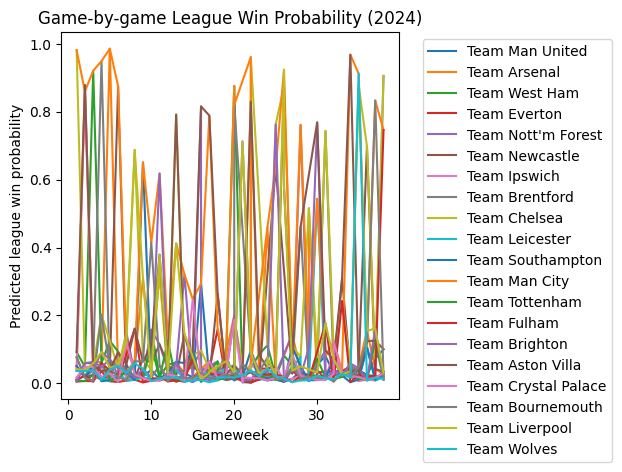

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

drop_cols = [
    'Date', 'season_start', 'gameweek', 'ft_result_encoded',
    'home_points', 'away_points', 'winner_team_encoded', 'points',
    'home_is_future_winner', 'away_is_future_winner', 'is_winner',
    'team_encoded', 'data_type', 'home_points_cum', 'away_points_cum'
]

# 1. Features & target
X = team_games.drop(columns=drop_cols, errors='ignore')
y = team_games['is_winner']

train_mask = team_games['season_start'] < 2024
test_mask  = team_games['season_start'] == 2024

X_train_raw, y_train = X[train_mask], y[train_mask]
X_test_raw,  y_test  = X[test_mask],  y[test_mask]

# 2. Imputer + scaler fitted on TRAIN ONLY
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train_raw)
X_train_scaled  = scaler.fit_transform(X_train_imputed)

X_test_imputed  = imputer.transform(X_test_raw)
X_test_scaled   = scaler.transform(X_test_imputed)

# 3. Fit logistic regression
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Optional: check test performance
print("Test positive rate:", y_test.mean())
print("Predicted positive rate:", model.predict_proba(X_test_scaled)[:, 1].mean())

X_all_imputed = imputer.transform(X)
X_all_scaled  = scaler.transform(X_all_imputed)

team_games['league_win_prob'] = model.predict_proba(X_all_scaled)[:, 1]


# Example: visualize for one season
season = 2024
subset = team_games[team_games['season_start'] == season]

for team in subset['team_encoded'].unique():
    #un-encode team
    team_unencoded = team_encoder.inverse_transform([team])[0]
    team_data = subset[subset['team_encoded'] == team].sort_values('gameweek')
    plt.plot(team_data['gameweek'], team_data['league_win_prob'], label=f'Team {team_unencoded}')

plt.xlabel('Gameweek')
plt.ylabel('Predicted league win probability')
plt.title(f'Game-by-game League Win Probability ({season})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [72]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print("Average precision (AUPRC):", average_precision_score(y_test, y_pred_prob))

ROC AUC: 0.6897506925207757
Average precision (AUPRC): 0.08186783347996279


In [73]:
pred_summary = (
    team_games.groupby(['season_start', 'team_encoded'])['league_win_prob']
    .mean()
    .reset_index()
    .sort_values(['season_start', 'league_win_prob'], ascending=[True, False])
)

print(pred_summary[pred_summary['season_start'] == 2024].head(10))


     season_start  team_encoded  league_win_prob
195        2024.0            22         0.521726
188        2024.0            11         0.297871
184        2024.0             1         0.275854
194        2024.0            20         0.177298
183        2024.0             0         0.157050
198        2024.0            27         0.139773
186        2024.0             7         0.109763
197        2024.0            25         0.104657
187        2024.0             8         0.093606
201        2024.0            38         0.088738


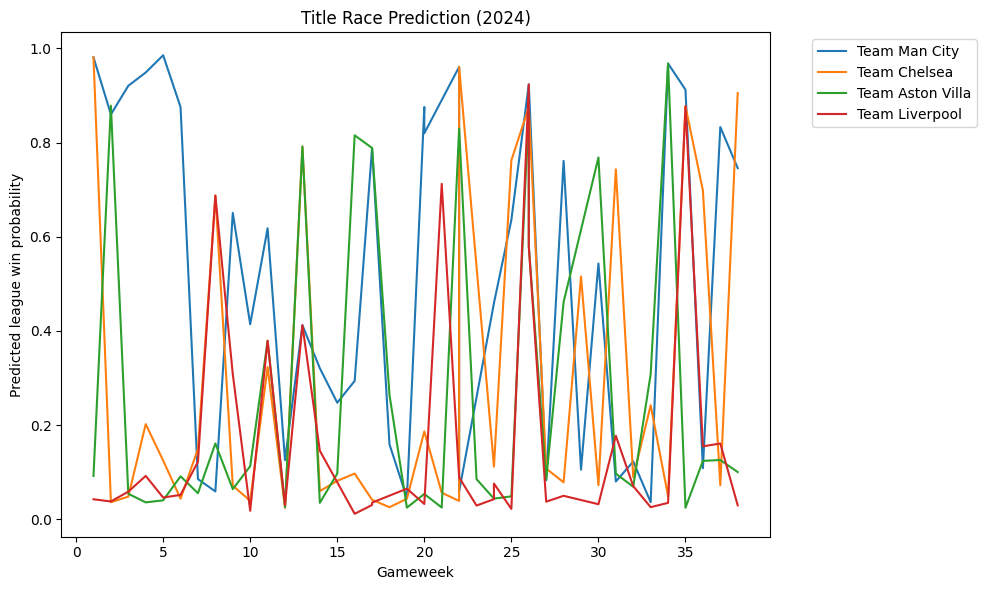

In [77]:
season = 2024
subset = team_games[team_games['season_start'] == season]

# Get top 6 contenders by average league_win_prob
top_teams = (
    subset.groupby('team_encoded')['league_win_prob']
    .mean()
    .sort_values(ascending=False)
    .head(4)
    .index
)

plt.figure(figsize=(10,6))
for team in top_teams:
    team_unencoded = team_encoder.inverse_transform([team])[0]
    team_data = subset[subset['team_encoded'] == team].sort_values('gameweek')
    plt.plot(team_data['gameweek'], team_data['league_win_prob'], label=f'Team {team_unencoded}')

plt.xlabel('Gameweek')
plt.ylabel('Predicted league win probability')
plt.title(f'Title Race Prediction ({season})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
